**Imports**

In [153]:
import pandas as pd
from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import copy

**Load data**

In [154]:

# fetch dataset 
statlog_german_credit_data = fetch_ucirepo(id=144) 
  
# data (as pandas dataframes) 
X = statlog_german_credit_data.data.features 
y = statlog_german_credit_data.data.targets 

**Prepare data**

In [155]:
# convert object data type to numericals
for column in X:
    if X[column].dtype == 'object':
        X[column] = X[column].astype('category').cat.codes
        
# split data into train, validation & test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.75, random_state=42)


/tmp/ipykernel_10784/3071087321.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = X[column].astype('category').cat.codes
/tmp/ipykernel_10784/3071087321.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = X[column].astype('category').cat.codes
/tmp/ipykernel_10784/3071087321.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

**Data exploration \(based on training data\)**

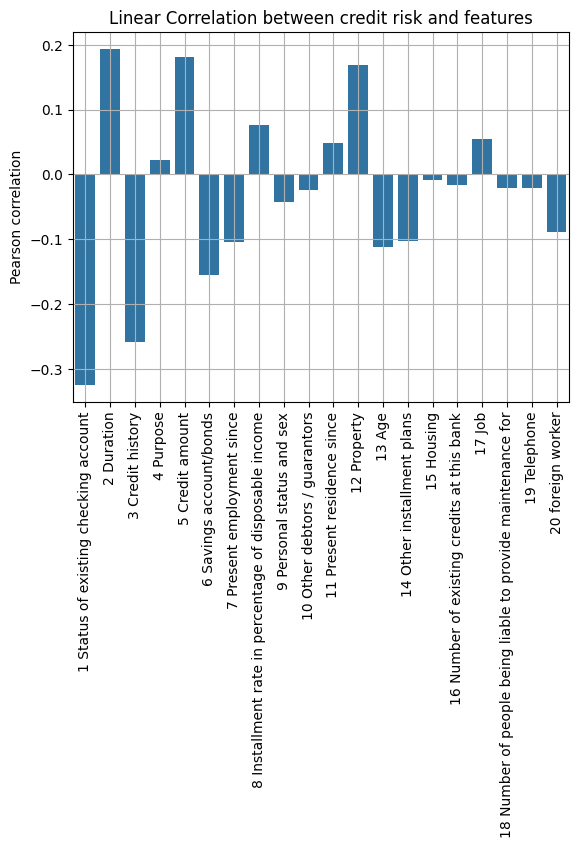

In [156]:
# Do linear correlation assessement
correlation_coef = []
attributes = []
for idx, (column, attribute_name) in enumerate(zip(X_train, statlog_german_credit_data.variables.description)):
    correlation_coef.append(X_train[column].corr(y_train['class']))
    attributes.append(str(idx+1) + " " + attribute_name)

# plot results
sns.barplot(x=attributes, y=correlation_coef)
plt.title('Linear Correlation between credit risk and features')
plt.xticks(rotation = 90)
plt.ylabel('Pearson correlation')
plt.grid()

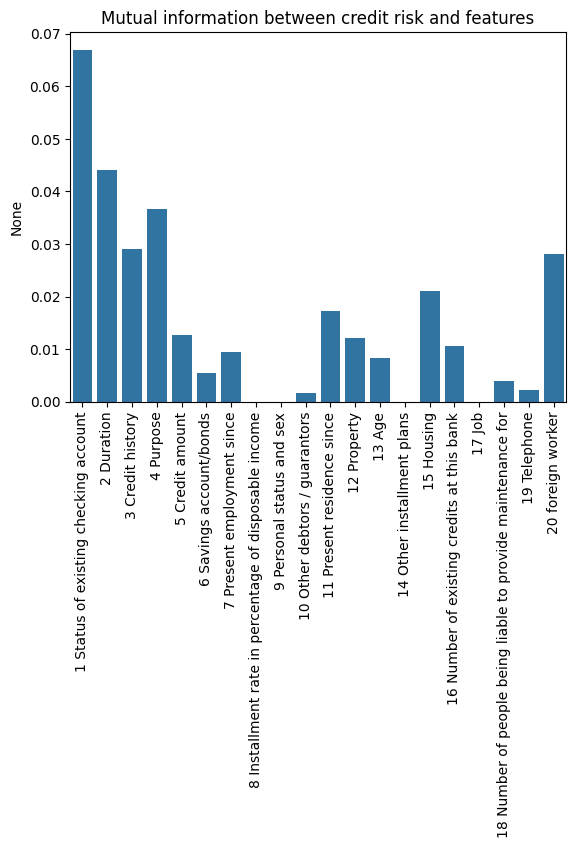

In [157]:
# Nonlinear interactions --> Mutual information

mi = mutual_info_classif(X_train, y_train["class"], random_state=42)
mi_series = pd.Series(mi, index=X_train.columns)

sns.barplot(x=attributes, y=mi_series)
plt.title('Mutual information between credit risk and features')
plt.xticks(rotation = 90)
plt.show()

Text(0.5, 1.0, 'Pearson correlation coeeficient of features')

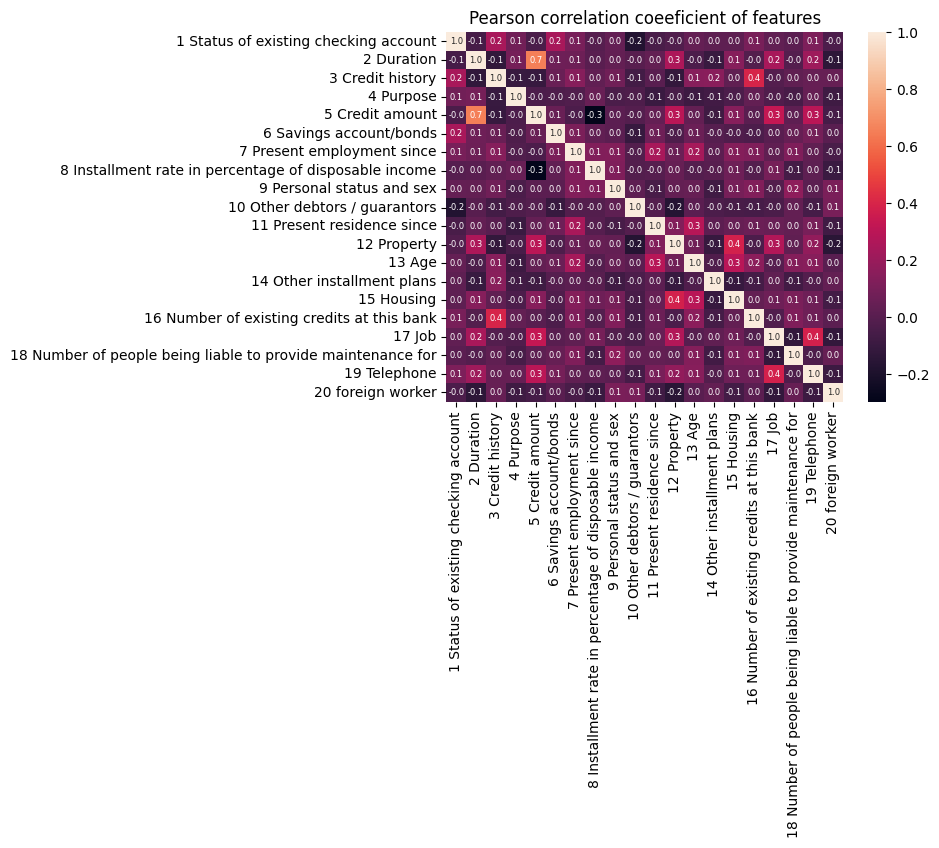

In [158]:
# Feature correlation
feature_corr = X_train.corr()

# plot
sns.heatmap(feature_corr, annot=True, fmt=".1f", annot_kws={"size": 6}, xticklabels=attributes,  yticklabels=attributes)
plt.title('Pearson correlation coeeficient of features')


In [159]:
# retain original data for future evaluation of feature removal
X_train_original = copy.deepcopy(X_train)
X_val_original = copy.deepcopy(X_val)
X_test = copy.deepcopy(X_test)

# remove all features with very low correlation or very low mutual information
for column, coef, mi, attribute in zip(X_train, correlation_coef, mi_series, attributes):
    if abs(coef) < 0.05 or mi < 0.005:
        X_train.drop(columns=column)
        X_val.drop(columns=column)
        X_test.drop(columns=column)
        print(column + " - " + attribute + " dropped.")

Attribute4 - 4 Purpose dropped.
Attribute8 - 8 Installment rate in percentage of disposable income dropped.
Attribute9 - 9 Personal status and sex dropped.
Attribute10 - 10 Other debtors / guarantors dropped.
Attribute11 - 11 Present residence since dropped.
Attribute14 - 14 Other installment plans dropped.
Attribute15 - 15 Housing dropped.
Attribute16 - 16 Number of existing credits at this bank dropped.
Attribute17 - 17 Job dropped.
Attribute18 - 18 Number of people being liable to provide maintenance for dropped.
Attribute19 - 19 Telephone dropped.


**Modeling**

/home/simon/anaconda3/envs/credit/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Text(0.5, 1.0, 'Validation results: Accuracy 0.73')

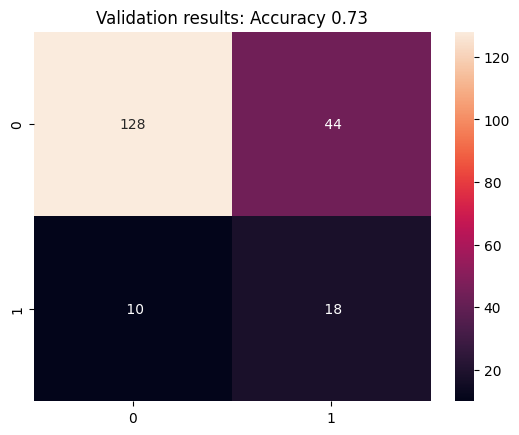

In [166]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
predictions = rfc.predict(X_val)
acc = accuracy_score(predictions, y_val)

# plot results
sns.heatmap(confusion_matrix(predictions, y_val), annot=True, fmt="3")
plt.title("Validation results: Accuracy " + str(acc))